# Walk Foward Evaluation

This section mimics a real-life like approach, where a model is trained on a week worth of data, and then used to predict 7 days worth of predictions.

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.16.1
pandas: 0.24.1
statsmodels: 0.9.0
sklearn: 0.19.0
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.2


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS10' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=None
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA', 'IOWAIT_DELTA']# Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1
n_estimators=100

# LSTM Network Structure
epochs=50
batch=64
activation='tanh'
initializer='normal'
dropout=0.4
layer=2
state=False

### Read data from file into Pandas Dataframes

In [3]:
# Root path
root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
#root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot_table(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot_table(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape) + '\n')

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12308, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (12323, 163)
Table [REP_HIST_SYSSTAT] - (12107, 1180)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'PLAN_HASH_VALUE' 'OPTIMIZER_COST'
 'OPTIMIZER_ENV_HASH_VALUE' 'SHARABLE_MEM' 'LOADED_VERSIONS'
 'VERSION_COUNT' 'SQL_PROFILE' 'PARSING_SCHEMA_ID' 'PARSING_USER_ID'
 'FETCHES_TOTAL' 'FETCHES_DELTA' 'END_OF_FETCH_COUNT_TOTAL'
 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL' 'SORTS_DELTA' 'EXECUTIONS_TOTAL'
 'EXECUTIONS_DELTA' 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA'
 'LOADS_TOTAL' 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED

### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['VM OUT BYTES PER SEC']

REP_HIST_SYSSTAT Features 1180: ['BA SPARE STATISTIC 12', 'BA SPARE STATISTIC 9', 'CLI FLSTASK CREATE', 'CLUSTERWIDE GLOBAL TRANSACTIONS', 'DDL STATEMENTS PARALLELIZED', 'EHCC COMPRESSED LENGTH COMPRESSED', 'EFFECTIVE IO TIME', 'FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM POPULATE (FASTSTART) CUS READ ATTEMPTS', 'IM POPULATE CUS MEMCOMPRESS FOR CAPACITY LOW', 'IM REPOPULATE (TRICKLE) CUS MEMCOMPRESS FOR QUERY LOW', 'IM REPOPULATE (TRICKLE) CUS REQUESTED', 'IM REPOPULATE CUS NO MEMCOMPRESS', 'IM SCAN ROWS JOURNAL', 'IM SCAN ROWS PROJECTED', 'IM SPACE SMU BYTES ALLOCATED', 'IM SPACE SMU CREATIONS COMMITTED', 'IM SPACE PRIVATE JOURNAL EXTENTS ALLOCATED', 'IPC CPU USED BY THIS SESSION', 'PARALLEL OPERATIONS DOWNGRADED TO SERIAL', 'WORKLOAD REPLAY: THINK TIME', 'BACKUP DATA COMPRESSED REMOTELY', 'CALLS TO KCMGRS', 'CELL CUS SENT UNCOMPRESSED', 'CONSISTENT GETS', 'DATA WAREH

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
print
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(12019, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLS

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(12019, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(12019, 1418)


### Redundant Feature Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(12019, 1418)

Shape before changes: [(12019, 1418)]
Shape after changes: [(12019, 536)]
Dropped a total [882]

After flatline column drop:
(12019, 536)

After additional column drop:
(12019, 526)


### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [ ]:
def detect_and_transform_outliers_zscore(df, threshold=3):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        counter = 0
        for val in df[col]:
            z_score = (val - mean) / std
            if np.abs(z_score) > threshold:
                df[col].iloc[counter] = 0
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

def detect_and_transform_outliers_iqr(df):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        quartile_1, quartile_3 = np.percentile(df.values, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        
        counter = 0
        for val in df[col]:
            if (val > upper_bound) or (val < lower_bound):
                df[col].iloc[counter] = 0
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

# df[[y_label[0]]] = detect_and_transform_outliers_zscore(df=df[[y_label[0]]], threshold=3)
# df[[y_label[1]]] = detect_and_transform_outliers_zscore(df=df[[y_label[1]]], threshold=1)

df[[y_label[0]]] = detect_and_transform_outliers_iqr(df=df[[y_label[0]]])
df[[y_label[1]]] = detect_and_transform_outliers_iqr(df=df[[y_label[1]]])

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.show()
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [11]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values, feature_range=(0, 1))
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------DF------------------')
print(df.shape)
print('\n')
#print(df.head())
#
# ROBUST SCALER
# df = Normalizer.robust_scaler(dataframe=df)
#
# MINMAX SCALER
#df = Normalizer.minmax_scaler(dataframe=df)
train, test = train_test_split(df, test_size=0.5)
trainheaders = train.columns
testheaders = test.columns
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=trainheaders)
test = pd.DataFrame(test, columns=testheaders)
df = train.append(test, ignore_index=True)
#
# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

------------------BEFORE------------------
------------------DF------------------
(12019, 526)




------------------AFTER------------------
------------------df------------------
(12019, 526)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.998472    8.777075e-12      0.007396       0.009714       0.001205   
1  0.389704    5.131039e-08      0.039771       0.361131       0.041842   
2  0.737091    4.105633e-11      0.006090       0.008611       0.001459   
3  0.546211    9.216495e-12      0.007528       0.002956       0.007857   
4  0.691797    6.892552e-12      0.004115       0.008685       0.001692   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.012934                  0.001238     0.014401   
1                  0.300642                  0.024440     0.500050   
2                  0.006827                  0.002723     0.013067   
3                  0.017649                  0.019456     0.011738  

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [12]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (12019, 2)
Feature matrix shape: (12019, 526)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.998472    8.777075e-12      0.007396       0.009714       0.001205   
1  0.389704    5.131039e-08      0.039771       0.361131       0.041842   
2  0.737091    4.105633e-11      0.006090       0.008611       0.001459   
3  0.546211    9.216495e-12      0.007528       0.002956       0.007857   
4  0.691797    6.892552e-12      0.004115       0.008685       0.001692   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.012934                  0.001238     0.014401   
1                  0.300642                  0.024440     0.500050   
2                  0.006827                  0.002723     0.013067   
3                  0.017649                  0.019456     0.011738   
4                  0.008094                  0.002475     0.013007   

   SORTS_DELTA  EXECUTIONS_TOTAL  

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [13]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))
#
io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 9853
Number of 1s: 2166
I/O y:
[0 1]
Number of 0s: 10048
Number of 1s: 1971


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)

    for i in range(1, n + 1):
        for header in headers:
            if "(t+" + str(i) + ")" in header:
                dropped_headers.append(str(header))

    return df.drop(dropped_headers, axis=1)


# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Separate labels from features
y_row = []
for i in range(lag + 1, (lag * 2) + 2):
    y_df_column_names = shifted_df.columns[len(df.columns) * i:len(df.columns) * i + len(y_label)]
    y_row.append(y_df_column_names)
    print(y_df_column_names)
    print(type(y_df_column_names))
y_df_column_names = []
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df
# X_df = shifted_df.drop(columns=y_df_column_names)

# # Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

Index(['var1(t+1)', 'var2(t+1)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+2)', 'var2(t+2)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+3)', 'var2(t+3)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+4)', 'var2(t+4)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+5)', 'var2(t+5)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+6)', 'var2(t+6)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+7)', 'var2(t+7)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+8)', 'var2(t+8)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+9)', 'var2(t+9)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+10)', 'var2(t+10)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+11)', 'var2(t+11)'], dtype='object')
<class 'pandas.core.indexes.base.Ind

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [15]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var128(t-4)', 'var129(t-4)', 'var130(t-4)', 'var131(t-4)', 'var132(t-4)', 'var133(t-4)', 'var134(t-4)', 'var135(t-4)', 'var136(t-4)', 'var137(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var144(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var152(t-4)', 'var153(t-4)', 'var154(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var161(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var169(t-4)', 'var170(t-4)', 'var171(t-4)', 'var172(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var192(t-4)', 'var193(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var216(t-4)', 'var217(t-4)', 'var218(t-4)', 'var219(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var223(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var233(t-4)', 'var234(t-4)', 'var236(t-4)', 'var237(t-4)', 'var238(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var243(t-4)', 'var244(t-4)', 'var245(t-4)', 'var246(t-4)', 'var247(t-4)', 'var248(t-4)', 'var251(t-4)', 'var252(t-4)', 'var253(t-4)', 'var255(t-4)', 'var257(t-4)', 'var261(t-4)', 'var262(t-4)', 'var265(t-4)', 'var267(t-4)', 'var268(t-4)', 'var269(t-4)', 'var270(t-4)', 'var271(t-4)', 'var273(t-4)', 'var274(t-4)', 'var277(t-4)', 'var279(t-4)', 'var280(t-4)', 'var285(t-4)', 'var286(t-4)', 'var290(t-4)', 'var293(t-4)', 'var294(t-4)', 'var295(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var300(t-4)', 'var310(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var315(t-4)', 'var317(t-4)', 'var318(t-4)', 'var319(t-4)', 'var320(t-4)', 'var321(t-4)', 'var323(t-4)', 'var324(t-4)', 'var325(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var329(t-4)', 'var330(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var340(t-4)', 'var341(t-4)', 'var343(t-4)', 'var348(t-4)', 'var351(t-4)', 'var352(t-4)', 'var353(t-4)', 'var354(t-4)', 'var362(t-4)', 'var363(t-4)', 'var364(t-4)', 'var365(t-4)', 'var366(t-4)', 'var367(t-4)', 'var368(t-4)', 'var370(t-4)', 'var374(t-4)', 'var375(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var380(t-4)', 'var381(t-4)', 'var382(t-4)', 'var385(t-4)', 'var386(t-4)', 'var388(t-4)', 'var389(t-4)', 'var390(t-4)', 'var391(t-4)', 'var393(t-4)', 'var394(t-4)', 'var395(t-4)', 'var396(t-4)', 'var397(t-4)', 'var398(t-4)', 'var399(t-4)', 'var400(t-4)', 'var401(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var406(t-4)', 'var407(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var454(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var467(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var506(t-4)', 'var507(t-4)', 'var508(t-4)', 'var509(t-4)', 'var510(t-4)', 'var511(t-4)', 'var512(t-4)', 'var513(t-4)', 'var514(t-4)', 'var515(t-4)', 'var516(t-4)', 'var517(t-4)', 'var518(t-4)', 'var519(t-4)', 'var520(t-4)', 'var521(t-4)', 'var522(t-4)', 'var523(t-4)', 'var524(t-4)', 'var525(t-4)', 'var526(t-4)', 'var1(t-3)', 'var2(t-3)', 'var4(t-3)', 'var5(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var12(t-3)', 'var13(t-3)', 'var15(t-3)', 'var19(t-3)', 'var20(t-3)', 'var21(t-3)', 'var22(t-3)', 'var28(t-3)', 'var29(t-3)', 'var38(t-3)', 'var40(t-3)', 'var41(t-3)', 'var42(t-3)', 'var43(t-3)', 'var44(t-3)', 'var45(t-3)', 'var46(t-3)', 'var47(t-3)', 'var49(t-3)', 'var50(t-3)', 'var51(t-3)', 'var53(t-3)', 'var54(t-3)', 'var56(t-3)', 'var59(t-3)', 'var60(t-3)', 'var61(t-3)', 'var62(t-3)', 'var63(t-3)', 'var64(t-3)', 'var74(t-3)', 'var75(t-3)', 'var78(t-3)', 'var79(t-3)', 'var81(t-3)', 'var83(t-3)', 'var85(t-3)', 'var86(t-3)', 'var88(t-3)', 'var89(t-3)', 'var91(t-3)', 'var92(t-3)', 'var93(t-3)', 'var94(t-3)', 'var95(t-3)', 'var96(t-3)', 'var97(t-3)', 'var99(t-3)', 'var102(t-3)', 'var103(t-3)', 'var104(t-3)', 'var106(t-3)', 'var111(t-3)', 'var114(t-3)', 'var124(t-3)', 'var125(t-3)', 'var130(t-3)', 'var131(t-3)', 'var132(t-3)', 'var133(t-3)', 'var134(t-3)', 'var148(t-3)', 'var152(t-3)', 'var154(t-3)', 'var156(t-3)', 'var163(t-3)', 'var164(t-3)', 'var166(t-3)', 'var171(t-3)', 'var172(t-3)', 'var174(t-3)', 'var175(t-3)', 'var176(t-3)', 'var178(t-3)', 'var180(t-3)', 'var181(t-3)', 'var183(t-3)', 'var184(t-3)', 'var185(t-3)', 'var186(t-3)', 'var187(t-3)', 'var188(t-3)', 'var189(t-3)', 'var191(t-3)', 'var192(t-3)', 'var193(t-3)', 'var196(t-3)', 'var197(t-3)', 'var201(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var233(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var239(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var255(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var260(t-3)', 'var261(t-3)', 'var262(t-3)', 'var263(t-3)', 'var264(t-3)', 'var265(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var275(t-3)', 'var276(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var291(t-3)', 'var293(t-3)', 'var294(t-3)', 'var295(t-3)', 'var296(t-3)', 'var297(t-3)', 'var298(t-3)', 'var299(t-3)', 'var300(t-3)', 'var301(t-3)', 'var302(t-3)', 'var303(t-3)', 'var304(t-3)', 'var305(t-3)', 'var306(t-3)', 'var307(t-3)', 'var308(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var312(t-3)', 'var313(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var324(t-3)', 'var325(t-3)', 'var326(t-3)', 'var327(t-3)', 'var328(t-3)', 'var331(t-3)', 'var332(t-3)', 'var333(t-3)', 'var334(t-3)', 'var335(t-3)', 'var340(t-3)', 'var341(t-3)', 'var342(t-3)', 'var343(t-3)', 'var351(t-3)', 'var352(t-3)', 'var353(t-3)', 'var354(t-3)', 'var355(t-3)', 'var356(t-3)', 'var358(t-3)', 'var359(t-3)', 'var360(t-3)', 'var361(t-3)', 'var364(t-3)', 'var367(t-3)', 'var370(t-3)', 'var371(t-3)', 'var373(t-3)', 'var374(t-3)', 'var376(t-3)', 'var378(t-3)', 'var379(t-3)', 'var384(t-3)', 'var387(t-3)', 'var388(t-3)', 'var389(t-3)', 'var391(t-3)', 'var392(t-3)', 'var393(t-3)', 'var394(t-3)', 'var395(t-3)', 'var399(t-3)', 'var400(t-3)', 'var401(t-3)', 'var404(t-3)', 'var405(t-3)', 'var406(t-3)', 'var407(t-3)', 'var411(t-3)', 'var412(t-3)', 'var413(t-3)', 'var414(t-3)', 'var419(t-3)', 'var420(t-3)', 'var421(t-3)', 'var423(t-3)', 'var426(t-3)', 'var428(t-3)', 'var429(t-3)', 'var432(t-3)', 'var433(t-3)', 'var434(t-3)', 'var435(t-3)', 'var436(t-3)', 'var439(t-3)', 'var440(t-3)', 'var441(t-3)', 'var442(t-3)', 'var443(t-3)', 'var452(t-3)', 'var454(t-3)', 'var455(t-3)', 'var457(t-3)', 'var460(t-3)', 'var463(t-3)', 'var464(t-3)', 'var468(t-3)', 'var471(t-3)', 'var472(t-3)', 'var473(t-3)', 'var474(t-3)', 'var475(t-3)', 'var476(t-3)', 'var477(t-3)', 'var480(t-3)', 'var481(t-3)', 'var482(t-3)', 'var483(t-3)', 'var486(t-3)', 'var487(t-3)', 'var490(t-3)', 'var491(t-3)', 'var493(t-3)', 'var495(t-3)', 'var497(t-3)', 'var499(t-3)', 'var500(t-3)', 'var501(t-3)', 'var503(t-3)', 'var504(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var512(t-3)', 'var513(t-3)', 'var515(t-3)', 'var516(t-3)', 'var517(t-3)', 'var518(t-3)', 'var519(t-3)', 'var520(t-3)', 'var521(t-3)', 'var523(t-3)', 'var524(t-3)', 'var525(t-3)', 'var526(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var14(t-2)', 'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)', 'var27(t-2)', 'var28(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var34(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var38(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var42(t-2)', 'var43(t-2)', 'var45(t-2)', 'var46(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var51(t-2)', 'var53(t-2)', 'var54(t-2)', 'var55(t-2)', 'var56(t-2)', 'var60(t-2)', 'var63(t-2)', 'var64(t-2)', 'var65(t-2)', 'var69(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var89(t-2)', 'var90(t-2)', 'var91(t-2)', 'var92(t-2)', 'var93(t-2)', 'var104(t-2)', 'var122(t-2)', 'var126(t-2)', 'var127(t-2)', 'var129(t-2)', 'var140(t-2)', 'var141(t-2)', 'var142(t-2)', 'var143(t-2)', 'var144(t-2)', 'var148(t-2)', 'var150(t-2)', 'var153(t-2)', 'var154(t-2)', 'var168(t-2)', 'var170(t-2)', 'var171(t-2)', 'var172(t-2)', 'var173(t-2)', 'var179(t-2)', 'var181(t-2)', 'var186(t-2)', 'var189(t-2)', 'var198(t-2)', 'var199(t-2)', 'var203(t-2)', 'var218(t-2)', 'var219(t-2)', 'var221(t-2)', 'var225(t-2)', 'var226(t-2)', 'var227(t-2)', 'var230(t-2)', 'var231(t-2)', 'var232(t-2)', 'var233(t-2)', 'var234(t-2)', 'var235(t-2)', 'var236(t-2)', 'var239(t-2)', 'var240(t-2)', 'var241(t-2)', 'var243(t-2)', 'var244(t-2)', 'var245(t-2)', 'var249(t-2)', 'var250(t-2)', 'var251(t-2)', 'var252(t-2)', 'var253(t-2)', 'var254(t-2)', 'var255(t-2)', 'var256(t-2)', 'var257(t-2)', 'var258(t-2)', 'var259(t-2)', 'var260(t-2)', 'var262(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var267(t-2)', 'var268(t-2)', 'var269(t-2)', 'var270(t-2)', 'var271(t-2)', 'var272(t-2)', 'var273(t-2)', 'var274(t-2)', 'var275(t-2)', 'var276(t-2)', 'var277(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var283(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var293(t-2)', 'var294(t-2)', 'var295(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var300(t-2)', 'var301(t-2)', 'var302(t-2)', 'var303(t-2)', 'var304(t-2)', 'var305(t-2)', 'var306(t-2)', 'var307(t-2)', 'var308(t-2)', 'var310(t-2)', 'var311(t-2)', 'var312(t-2)', 'var313(t-2)', 'var314(t-2)', 'var315(t-2)', 'var316(t-2)', 'var317(t-2)', 'var318(t-2)', 'var319(t-2)', 'var320(t-2)', 'var322(t-2)', 'var323(t-2)', 'var324(t-2)', 'var325(t-2)', 'var326(t-2)', 'var327(t-2)', 'var328(t-2)', 'var329(t-2)', 'var330(t-2)', 'var332(t-2)', 'var336(t-2)', 'var343(t-2)', 'var347(t-2)', 'var362(t-2)', 'var363(t-2)', 'var368(t-2)', 'var376(t-2)', 'var377(t-2)', 'var380(t-2)', 'var381(t-2)', 'var383(t-2)', 'var384(t-2)', 'var386(t-2)', 'var393(t-2)', 'var395(t-2)', 'var397(t-2)', 'var398(t-2)', 'var399(t-2)', 'var405(t-2)', 'var406(t-2)', 'var408(t-2)', 'var409(t-2)', 'var411(t-2)', 'var412(t-2)', 'var413(t-2)', 'var414(t-2)', 'var418(t-2)', 'var420(t-2)', 'var426(t-2)', 'var428(t-2)', 'var432(t-2)', 'var433(t-2)', 'var434(t-2)', 'var435(t-2)', 'var436(t-2)', 'var437(t-2)', 'var438(t-2)', 'var441(t-2)', 'var442(t-2)', 'var452(t-2)', 'var453(t-2)', 'var481(t-2)', 'var486(t-2)', 'var488(t-2)', 'var489(t-2)', 'var497(t-2)', 'var500(t-2)', 'var501(t-2)', 'var502(t-2)', 'var503(t-2)', 'var504(t-2)', 'var506(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var512(t-2)', 'var513(t-2)', 'var514(t-2)', 'var515(t-2)', 'var516(t-2)', 'var517(t-2)', 'var518(t-2)', 'var519(t-2)', 'var520(t-2)', 'var521(t-2)', 'var522(t-2)', 'var523(t-2)', 'var524(t-2)', 'var525(t-2)', 'var526(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var506(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var517(t-1)', 'var518(t-1)', 'var519(t-1)', 'var520(t-1)', 'var521(t-1)', 'var522(t-1)', 'var523(t-1)', 'var524(t-1)', 'var525(t-1)', 'var526(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var74(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var144(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var151(t)', 'var152(t)', 'var153(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var258(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var266(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var341(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)', 'var386(t)', 'var387(t)', 'var388(t)', 'var389(t)', 'var390(t)', 'var391(t)', 'var392(t)', 'var393(t)', 'var394(t)', 'var395(t)', 'var396(t)', 'var397(t)', 'var398(t)', 'var399(t)', 'var400(t)', 'var401(t)', 'var402(t)', 'var403(t)', 'var404(t)', 'var405(t)', 'var406(t)', 'var407(t)', 'var408(t)', 'var409(t)', 'var410(t)', 'var411(t)', 'var412(t)', 'var413(t)', 'var414(t)', 'var415(t)', 'var416(t)']
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var120(t-4)  var121(t-4)  var122(t-4)  var128(t-4)  var129(t-4)  \
12     0.000000     1.000000     0.010794          0.0     0.000000   
13     0.000000     1.000000     0.020230          0.0     0.000000   
14     0.000000     1.000000     0.005105          0.0     0.000000   
15     0.078350     0.877224     0.148630          0.0     0.000000   
16     0.009096     1.000000     0.034989          0.0     0.065036   

    var130(t-4)  var131(t-4)  var132(t-4)  var133(t-4)  var134(t-4)  ...  \
12     0.000000     0.000004     0.000007     0.000294     0.000334  ...   
13     0.000000     0.001811     0.003173     0.002139     0.003534  ...   
14     0.000000     0.000023     0.000008     0.000316     0.000338  ...   
15     0.000000     0.359864     0.276963     0.359838     0.276973  ...   
16     0.090909     0.069725     0.002752     0.069701     0.002780  ...   

    var407(t)  var408(t)  var409(t)  var410(t)  var411(t)  var412(t)  \
12   0.244925   0.451397   0.451363   0.3147

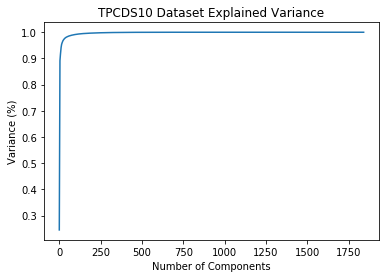

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0     8.681445    -0.453558    -6.224980    -1.268671    -0.349921   
1     0.426761    -6.952152     0.251047    -1.233415     5.960243   
2    -0.929029     0.215326     8.139413    -4.200637    -0.156986   
3    -7.292334     7.315493    -0.069083    -1.026108    -0.344585   
4    -1.830193     0.344836    -0.502287    -0.921396    -5.085957   

   Component_5  Component_6  Component_7  Component_8  Component_9  ...  \
0     1.771809     1.699206     1.016122     1.037822     0.561766  ...   
1    -1.017132     0.671139    -1.524092     0.650408    -0.300340  ...   
2    -0.999262    -0.572209     1.229085    -0.939445    -0.068413  ...   
3     1.084637     0.096548    -1.665989     0.312317    -0.319587  ...   
4    -0.761284    -0.548101     0.587832     0.938092     1.665677  ...   

   Component_75  Component_76  Component_77  Component_78  Component_79  \
0      0.060434     -0

In [16]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## LSTM Classification (Many to Many)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- The LSTM recurrent layer comprised of memory units is called LSTM().
- A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().
- The first layer in the network must define the number of inputs to expect.
- Input must be three-dimensional, comprised of samples, timesteps, and features.
    - **Samples:** These are the rows in your data.
    - **Timesteps:** These are the past observations for a feature, such as lag variables.
    - **Features:** These are columns in your data.
- Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [17]:
# LSTM Class
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', lstm_layers=1, dropout=.0,
                 stateful=False, y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param lstm_layers   - (Integer) Denotes the number of LSTM layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param stateful      - (Boolean) Denotes whether state is used as initial state for next training batch.
        :param: y_labels     - (List) List of target label names
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')
        
        # self.__model.add(ke.layers.Embedding(2+1, 32, input_length=X.shape[1]))
        for i in range(0, lstm_layers - 1):  # If lstm_layers == 1, this for loop logic is skipped.
            if stateful:
                if i == 0:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    batch_input_shape=(X.shape[0],
                                                                       X.shape[1],
                                                                       X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
                else:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    input_shape=(X.shape[1],
                                                                 X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                return_sequences=True,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                stateful=stateful))
            self.__model.add(ke.layers.Dropout(dropout))
        if lstm_layers > 1:
            self.__model.add(ke.layers.LSTM(X.shape[2],
                                            input_shape=(X.shape[1],
                                                         X.shape[2]),
                                            stateful=stateful,
                                            recurrent_dropout=dropout,
                                            recurrent_initializer=initializer,
                                            activation=activation,
                                            return_sequences=False))
        else:
            if stateful:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                batch_input_shape=(X.shape[0],
                                                                   X.shape[1],
                                                                   X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
        self.__model.add(ke.layers.Dropout(dropout))
        # self.__model.add(ke.layers.TimeDistributed(ke.layers.Dense(self.__lag * len(self.__y_labels), kernel_initializer=initializer)))
        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: batch_size - (Integer) Integer value denoting LSTM training batch_size
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during LSTM training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              stateful, rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained LSTM models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: batch      - (Integer) Integer denoting LSTM batch size.
        :param: epoch      - (Integer) Integer denoting number of LSTM training iterations.
        :param: layer      - (Integer) Integer denoting number of LSTM layers
        :param: activation - (String) String denoting activation for LSTM layers.
        :param: initializer- (String) String denoting LSTM initializing weights.
        :param: stateful   - (Bool) Boolean flag which denotes whether LSTM model is trained in stateful mode or not.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by LSTM training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'stateful', 'dropout', 'activation',
                       'initializer', 'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'stateful': stateful,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows, :]

### Time Step (1) - Training (CPU)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(5997, 1, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 1, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 12)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_intel_intel(r)_hd_graphics_520.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 85)             58140     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 85)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 85)                58140     
_________________________________________________________________
dropout_2 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1032      
Total params: 117,312
Trainable params: 117,312
Non-trainable params: 0
_________________________________________________________________
None
Train on 5997 samples, validate on 5998 samples
Epoch 1/50
 - 11s - loss: 0.0792 - mean_squared_error: 0.0792 - mean_absolute_error

Epoch 42/50
 - 4s - loss: 0.0737 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2304 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2439
Epoch 43/50
 - 4s - loss: 0.0737 - mean_squared_error: 0.0737 - mean_absolute_error: 0.2304 - val_loss: 0.0820 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2440
Epoch 44/50
 - 5s - loss: 0.0736 - mean_squared_error: 0.0736 - mean_absolute_error: 0.2304 - val_loss: 0.0821 - val_mean_squared_error: 0.0821 - val_mean_absolute_error: 0.2440
Epoch 45/50
 - 5s - loss: 0.0736 - mean_squared_error: 0.0736 - mean_absolute_error: 0.2303 - val_loss: 0.0821 - val_mean_squared_error: 0.0821 - val_mean_absolute_error: 0.2441
Epoch 46/50
 - 4s - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.2297 - val_loss: 0.0822 - val_mean_squared_error: 0.0822 - val_mean_absolute_error: 0.2442
Epoch 47/50
 - 4s - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.2295 - val_loss: 0.0823

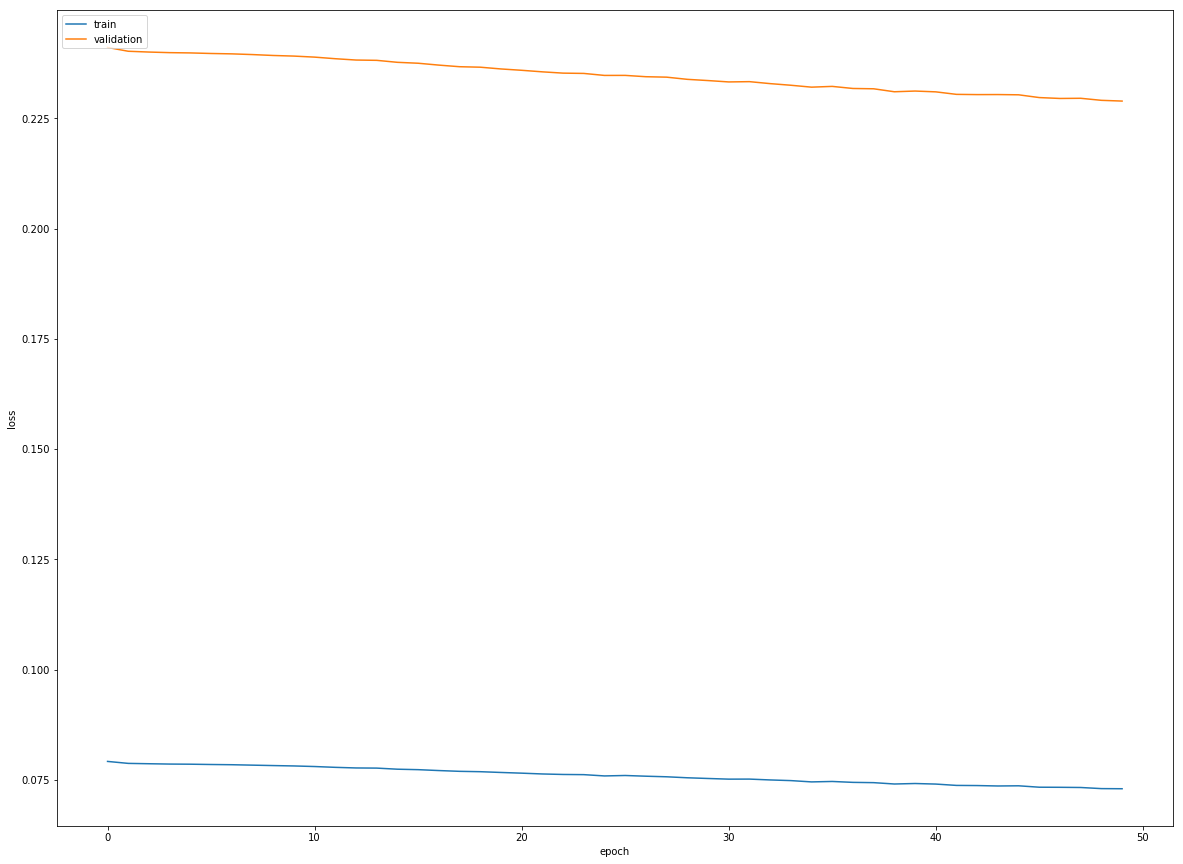

Wall time: 4min 7s


In [18]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

Day 1
Feature vectors: (856, 1, 85)
Label vectors: (856, 12)
Label: 0
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 1
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 2
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 3
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 4
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 5
Accuracy: 0.9871495327102804
F1Score: 0.993533215755438
--------------------------
Label: 6
Accuracy: 0.9906542056074766
F1Score: 0.9953051643192489
--------------------------
Label: 7
Accuracy: 0.9789719626168224
F1Score: 0.9893742621015349
--------------------------
Label: 8
Accuracy: 0.9766355140186916
F1Score: 0.988179669030733
--------------------------
Label: 9
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 10
A

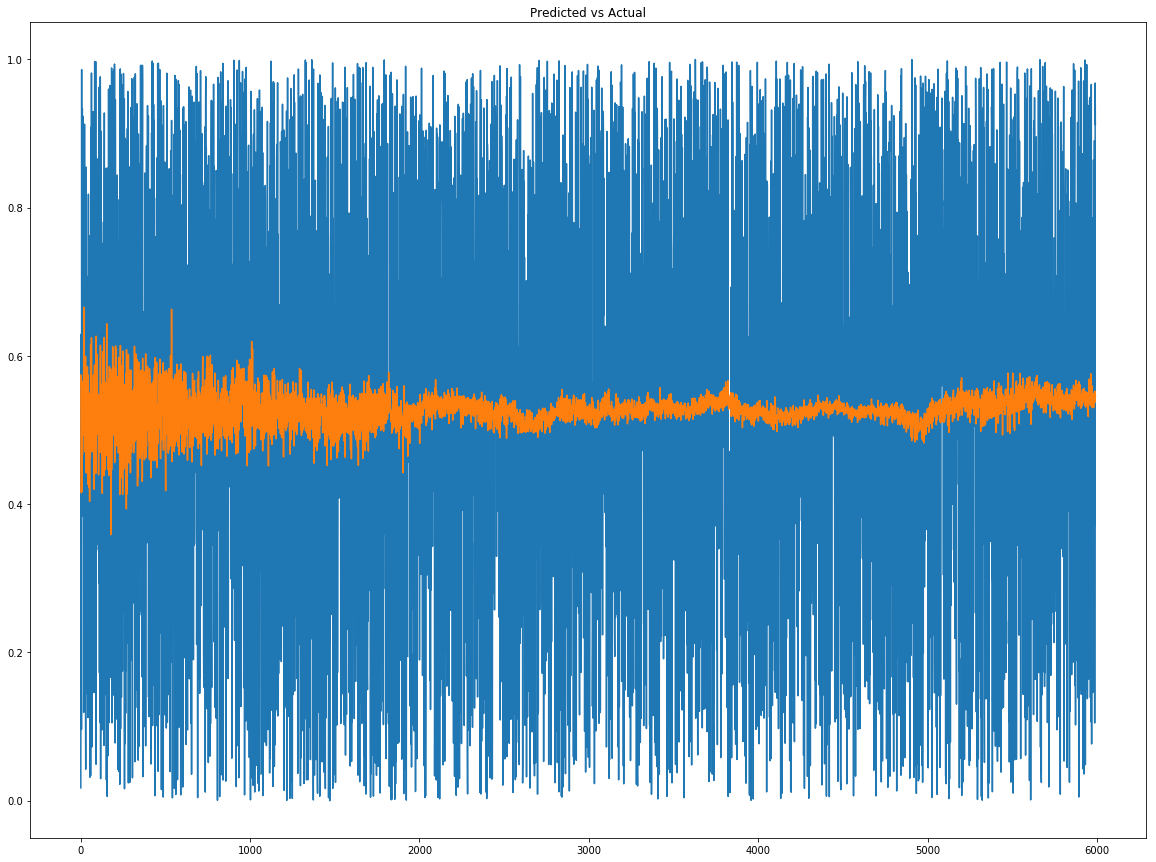

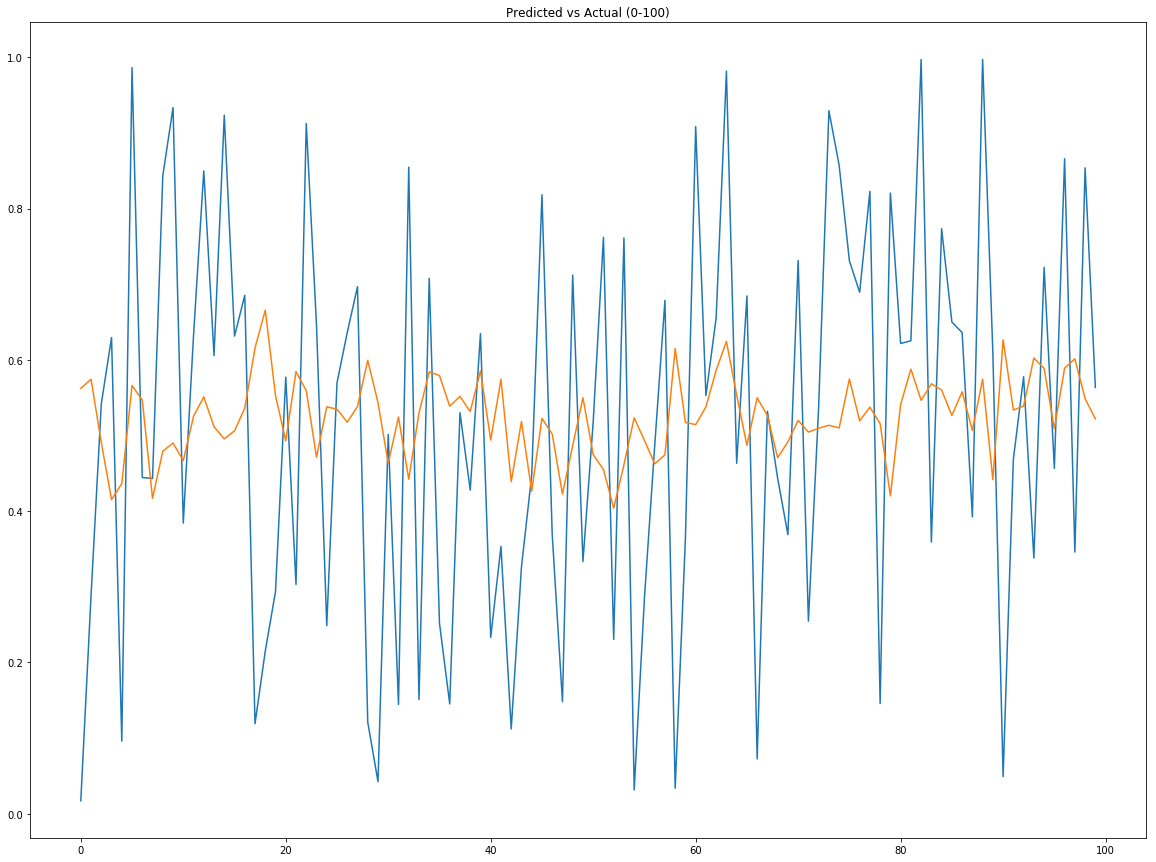

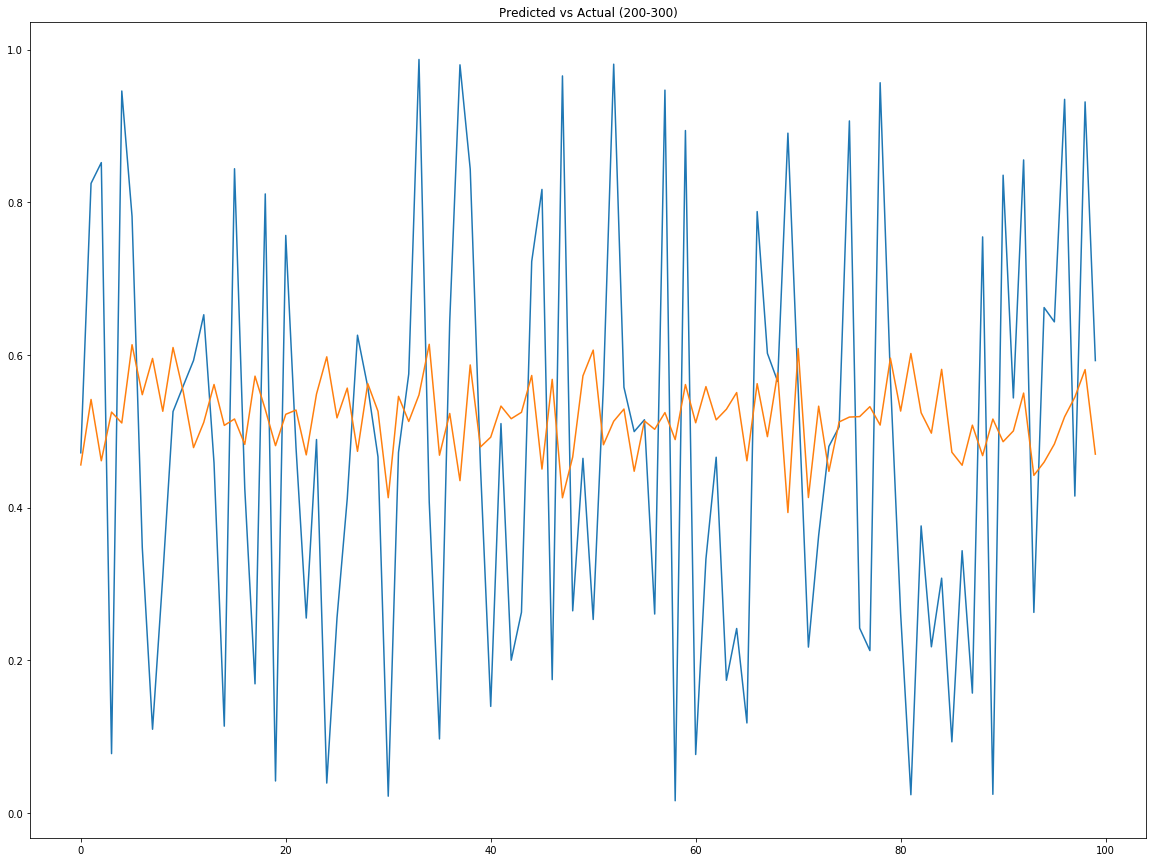

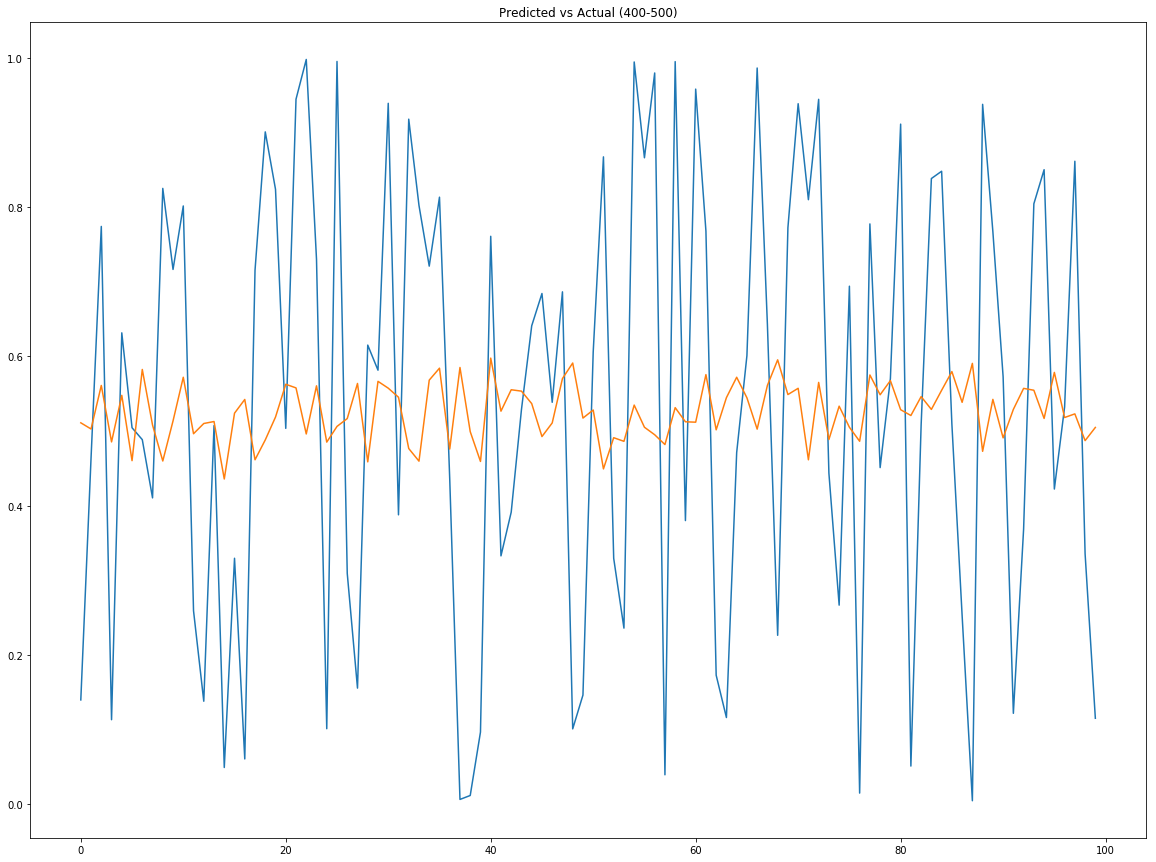

Wall time: 7min 18s


In [19]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], cpu_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

### Scoring per day  (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

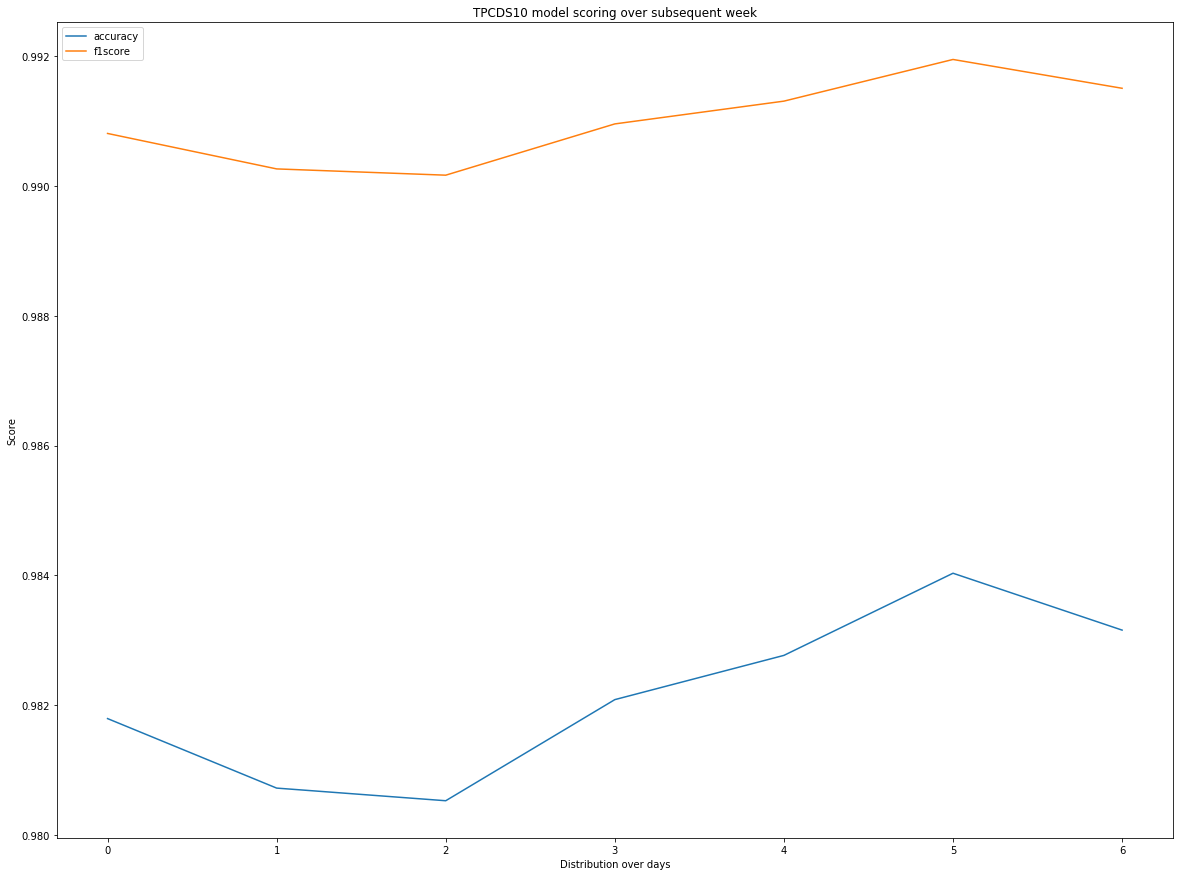

In [20]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(5997, 1, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 1, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 12)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 85)             58140     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 85)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 85)                58140     
_________________________________________________________________
dropout_4 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1032      
Tot

Epoch 37/50
 - 4s - loss: 3.2456e-04 - mean_squared_error: 3.2456e-04 - mean_absolute_error: 0.0017 - val_loss: 5.2326e-04 - val_mean_squared_error: 5.2326e-04 - val_mean_absolute_error: 0.0014
Epoch 38/50
 - 4s - loss: 3.2371e-04 - mean_squared_error: 3.2371e-04 - mean_absolute_error: 0.0017 - val_loss: 5.2327e-04 - val_mean_squared_error: 5.2327e-04 - val_mean_absolute_error: 0.0014
Epoch 39/50
 - 4s - loss: 3.2323e-04 - mean_squared_error: 3.2323e-04 - mean_absolute_error: 0.0016 - val_loss: 5.2329e-04 - val_mean_squared_error: 5.2329e-04 - val_mean_absolute_error: 0.0014
Epoch 40/50
 - 4s - loss: 3.2394e-04 - mean_squared_error: 3.2394e-04 - mean_absolute_error: 0.0016 - val_loss: 5.2330e-04 - val_mean_squared_error: 5.2330e-04 - val_mean_absolute_error: 0.0014
Epoch 41/50
 - 4s - loss: 3.2357e-04 - mean_squared_error: 3.2357e-04 - mean_absolute_error: 0.0016 - val_loss: 5.2332e-04 - val_mean_squared_error: 5.2332e-04 - val_mean_absolute_error: 0.0014
Epoch 42/50
 - 4s - loss: 3.23

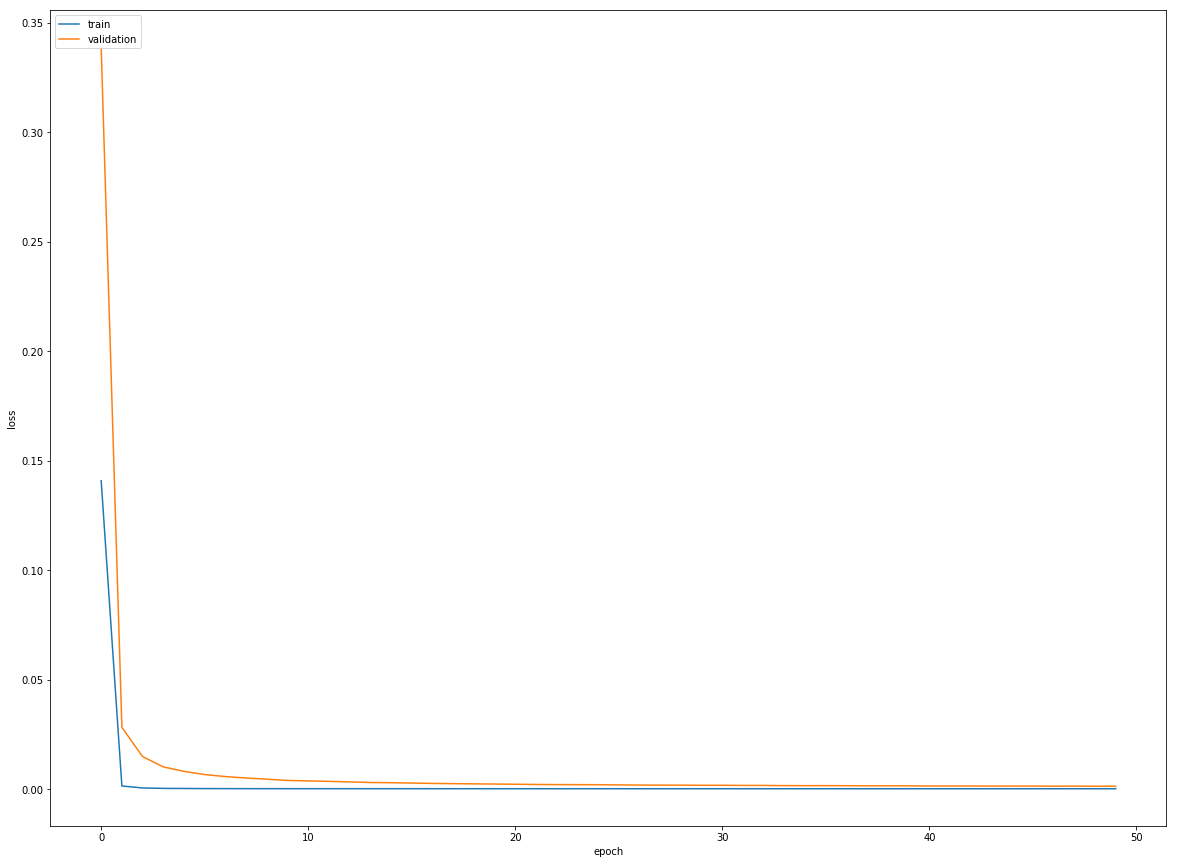

Wall time: 3min 48s


In [21]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [22]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[i] = BinClass.discretize_value(y[z], io_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

Day 1
Feature vectors: (856, 1, 85)
Label vectors: (856, 12)
Label: 0
Accuracy: 0.9754672897196262
F1Score: 0.0
--------------------------
Label: 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Classification metrics can't handle a mix of continuous and binary targets

### Scoring per day  (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

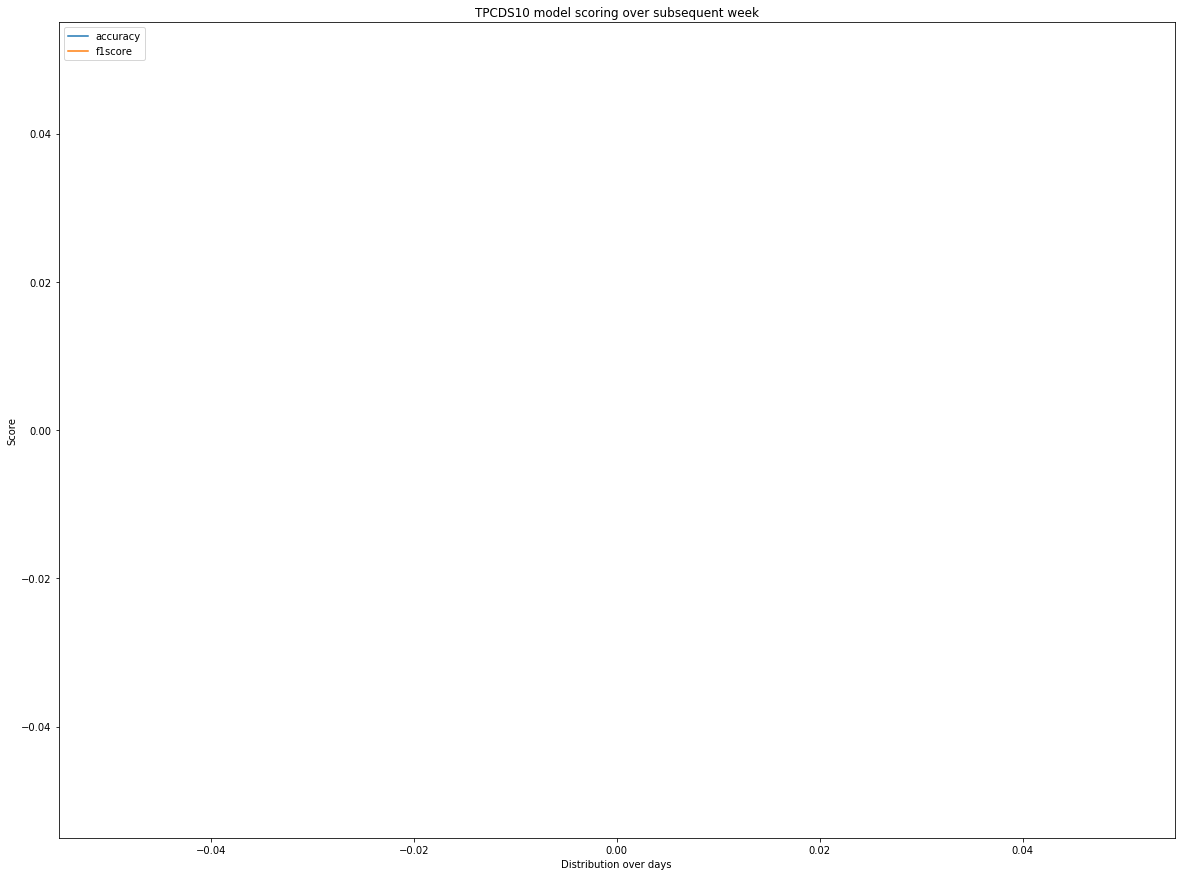

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(5997, 1, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(5997, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(5998, 1, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(5998, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 85)             58140     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 85)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 85)                58140     
_________________________________________________________________
dropout_6 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2064      
Tot

Epoch 40/50
 - 5s - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1224 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1220
Epoch 41/50
 - 5s - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1223 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1220
Epoch 42/50
 - 5s - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1222 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1219
Epoch 43/50
 - 5s - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1222 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1219
Epoch 44/50
 - 5s - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1222 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1219
Epoch 45/50
 - 5s - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1221 - val_loss: 0.0398

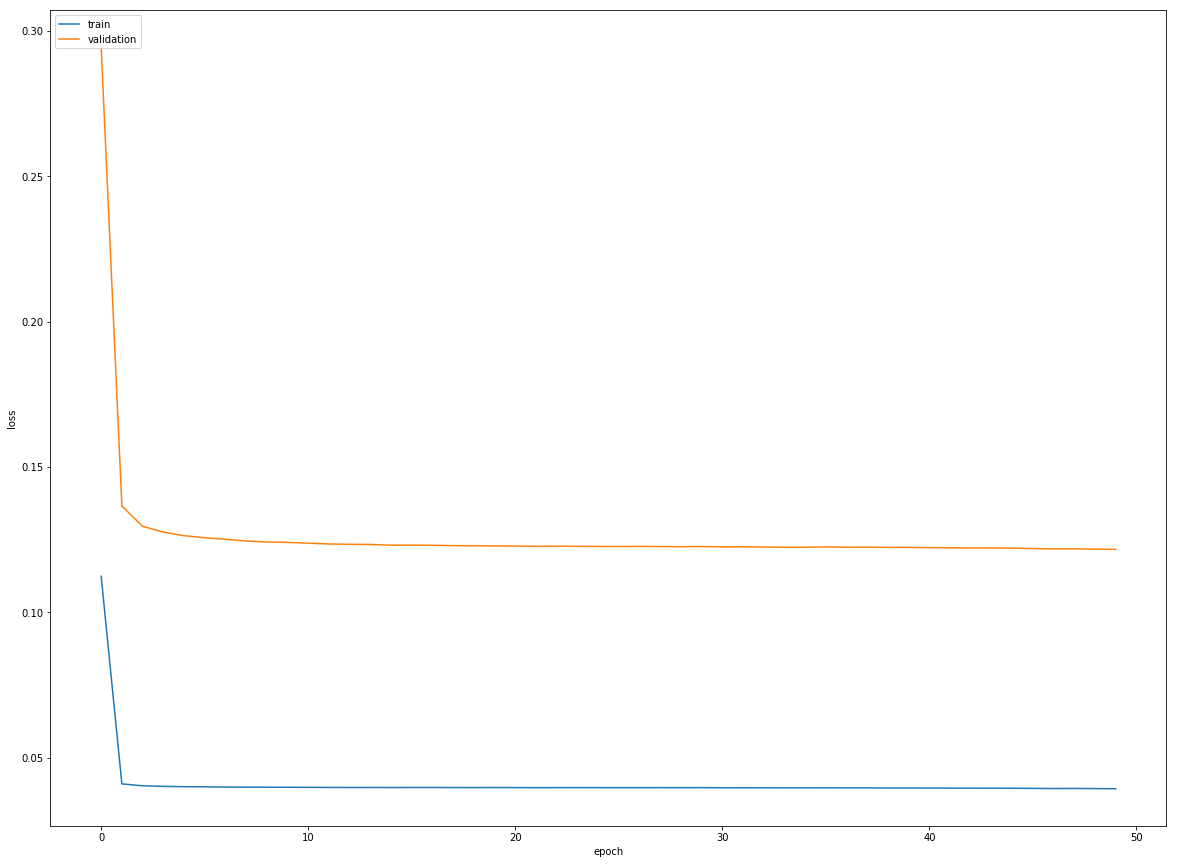

Wall time: 4min 4s


In [24]:
%%time
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [25]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (856, 1, 85)
Label vectors: (856, 24)
Label: 0
Accuracy: 0.9871495327102804
F1Score: 0.993533215755438
--------------------------
Label: 1
Accuracy: 0.9427570093457944
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 3
Accuracy: 0.9485981308411215
F1Score: 0.043478260869565216
--------------------------
Label: 4
Accuracy: 0.9719626168224299
F1Score: 0.985781990521327
--------------------------
Label: 5
Accuracy: 0.9521028037383178
F1Score: 0.08888888888888889
--------------------------
Label: 6
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 7
Accuracy: 0.947429906542056
F1Score: 0.0425531914893617
--------------------------
Label: 8
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 9
Accuracy: 0.9357476635514018
F1Score: 0.03508771929824562
--------------------------
Label: 10
Accuracy: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 1
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9801401869158879
F1Score: 0.9899705014749263
--------------------------
Label: 3
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9894859813084113
F1Score: 0.9947152084556665
--------------------------
Label: 5
Accuracy: 0.9836448598130841
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 7
Accuracy: 0.9801401869158879
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 9
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.977803738317757
F1Score: 0.9887773183697579
--------------------------
Label: 11
Accuracy: 0.9742990654205608
F1Score: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 1
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9789719626168224
F1Score: 0.9893742621015349
--------------------------
Label: 3
Accuracy: 0.977803738317757
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 5
Accuracy: 0.9801401869158879
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 7
Accuracy: 0.9836448598130841
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.977803738317757
F1Score: 0.9887773183697579
--------------------------
Label: 9
Accuracy: 0.9707943925233645
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 11
Accuracy: 0.9742990654205608
F1Score: 0.0
-

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 1
Accuracy: 0.9801401869158879
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 3
Accuracy: 0.9707943925233645
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 5
Accuracy: 0.9637850467289719
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 7
Accuracy: 0.9684579439252337
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 9
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.985981308411215
F1Score: 0.9929411764705882
--------------------------
Label: 11
Accuracy: 0.9789719626168224
F1Score: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9824766355140186
F1Score: 0.9911608721272834
--------------------------
Label: 1
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9789719626168224
F1Score: 0.9893742621015349
--------------------------
Label: 3
Accuracy: 0.977803738317757
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 5
Accuracy: 0.977803738317757
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 7
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9848130841121495
F1Score: 0.9923484402589758
--------------------------
Label: 9
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 11
Accuracy: 0.9789719626168224
F1Score: 0.0
-

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

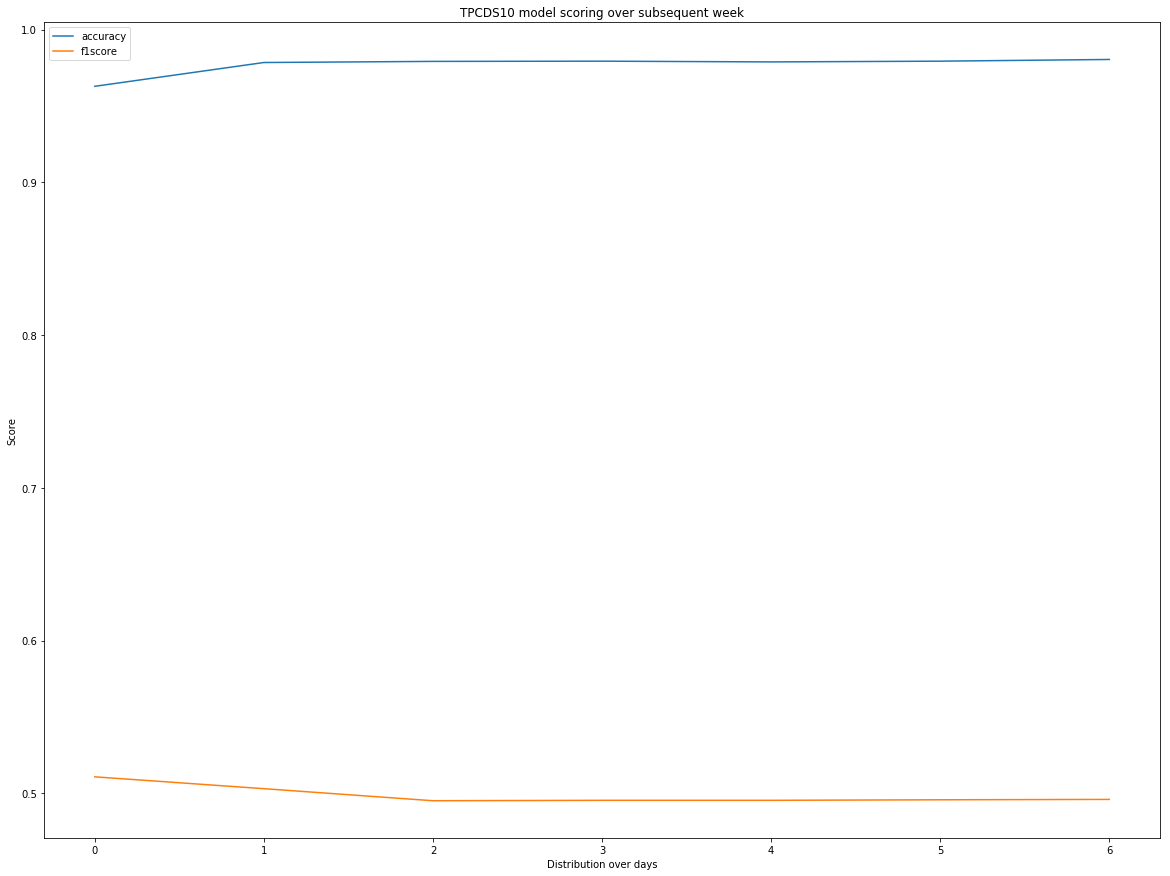

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (2) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(2998, 2, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(2998, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(2999, 2, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(2999, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 2, 85)             58140     
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 85)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 85)                58140     
_________________________________________________________________
dropout_8 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                2064      
Tot

Epoch 40/50
 - 3s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1225 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1237
Epoch 41/50
 - 3s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1225 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1237
Epoch 42/50
 - 3s - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1221 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1236
Epoch 43/50
 - 3s - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1220 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1235
Epoch 44/50
 - 3s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1218 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1236
Epoch 45/50
 - 3s - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1215 - val_loss: 0.0404

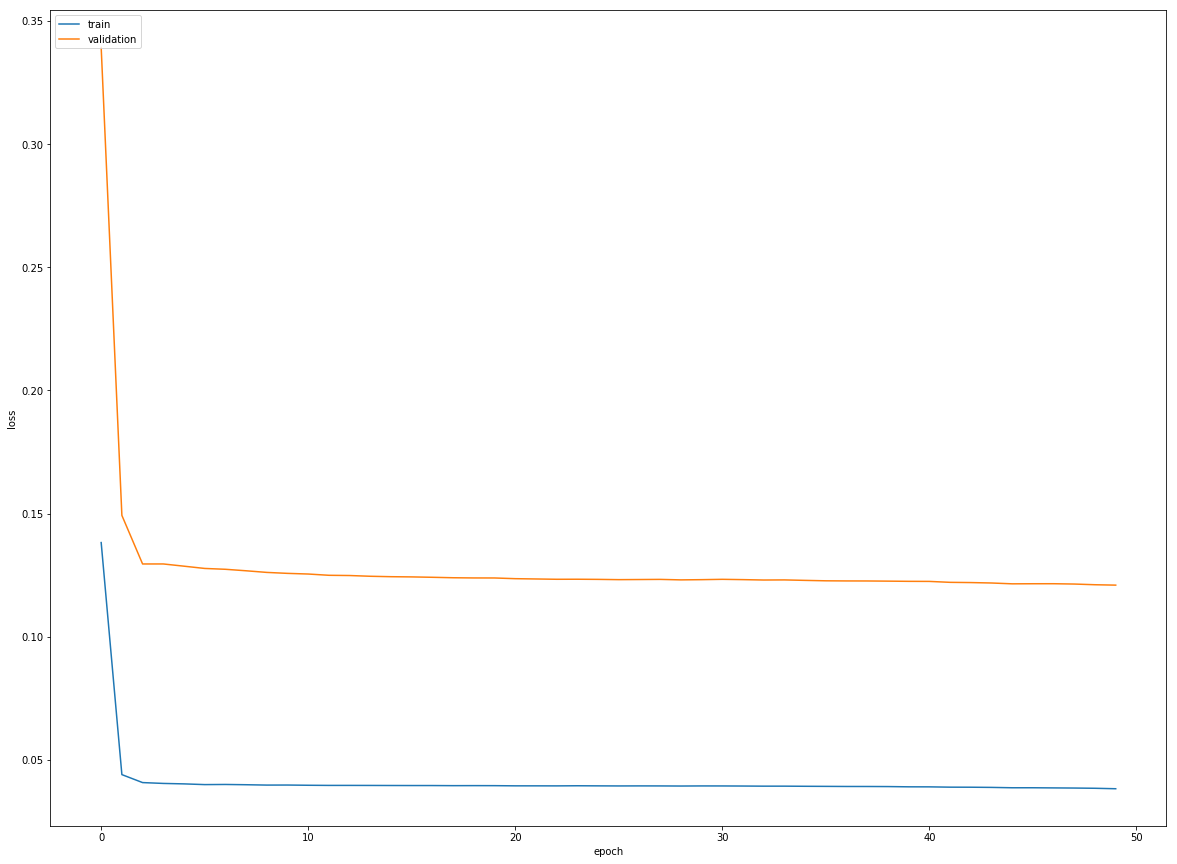

Wall time: 2min 48s


In [27]:
%%time
timestep = 2
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (2) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [28]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (428, 2, 85)
Label vectors: (428, 24)
Label: 0
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 1
Accuracy: 0.8714953271028038
F1Score: 0.03508771929824561
--------------------------
Label: 2
Accuracy: 0.9883177570093458
F1Score: 0.9941245593419507
--------------------------
Label: 3
Accuracy: 0.8808411214953271
F1Score: 0.13559322033898305
--------------------------
Label: 4
Accuracy: 0.9906542056074766
F1Score: 0.9953051643192489
--------------------------
Label: 5
Accuracy: 0.8761682242990654
F1Score: 0.03636363636363636
--------------------------
Label: 6
Accuracy: 0.9742990654205608
F1Score: 0.98698224852071
--------------------------
Label: 7
Accuracy: 0.8738317757009346
F1Score: 0.03571428571428571
--------------------------
Label: 8
Accuracy: 0.9789719626168224
F1Score: 0.9893742621015349
--------------------------
Label: 9
Accuracy: 0.8154205607476636
F1Score: 0.04819277108433735
--------------------------
Label:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.969626168224299
F1Score: 0.9845788849347568
--------------------------
Label: 1
Accuracy: 0.9906542056074766
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9766355140186916
F1Score: 0.988179669030733
--------------------------
Label: 3
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9719626168224299
F1Score: 0.985781990521327
--------------------------
Label: 5
Accuracy: 0.9883177570093458
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 7
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9742990654205608
F1Score: 0.98698224852071
--------------------------
Label: 9
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.985981308411215
F1Score: 0.9929411764705882
--------------------------
Label: 11
Accuracy: 0.9789719626168224
F1Score: 0.0
-----

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9789719626168224
F1Score: 0.9893742621015349
--------------------------
Label: 1
Accuracy: 0.969626168224299
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9742990654205608
F1Score: 0.98698224852071
--------------------------
Label: 3
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9929906542056075
F1Score: 0.9964830011723329
--------------------------
Label: 5
Accuracy: 0.985981308411215
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9742990654205608
F1Score: 0.98698224852071
--------------------------
Label: 7
Accuracy: 0.9836448598130841
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 9
Accuracy: 0.9742990654205608
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9742990654205608
F1Score: 0.98698224852071
--------------------------
Label: 11
Accuracy: 0.9719626168224299
F1Score: 0.0
-------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9836448598130841
F1Score: 0.9917550058892814
--------------------------
Label: 1
Accuracy: 0.9719626168224299
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9883177570093458
F1Score: 0.9941245593419507
--------------------------
Label: 3
Accuracy: 0.9883177570093458
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 5
Accuracy: 0.9766355140186916
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9906542056074766
F1Score: 0.9953051643192489
--------------------------
Label: 7
Accuracy: 0.9813084112149533
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9906542056074766
F1Score: 0.9953051643192489
--------------------------
Label: 9
Accuracy: 0.9789719626168224
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9813084112149533
F1Score: 0.9905660377358491
--------------------------
Label: 11
Accuracy: 0.9883177570093458
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

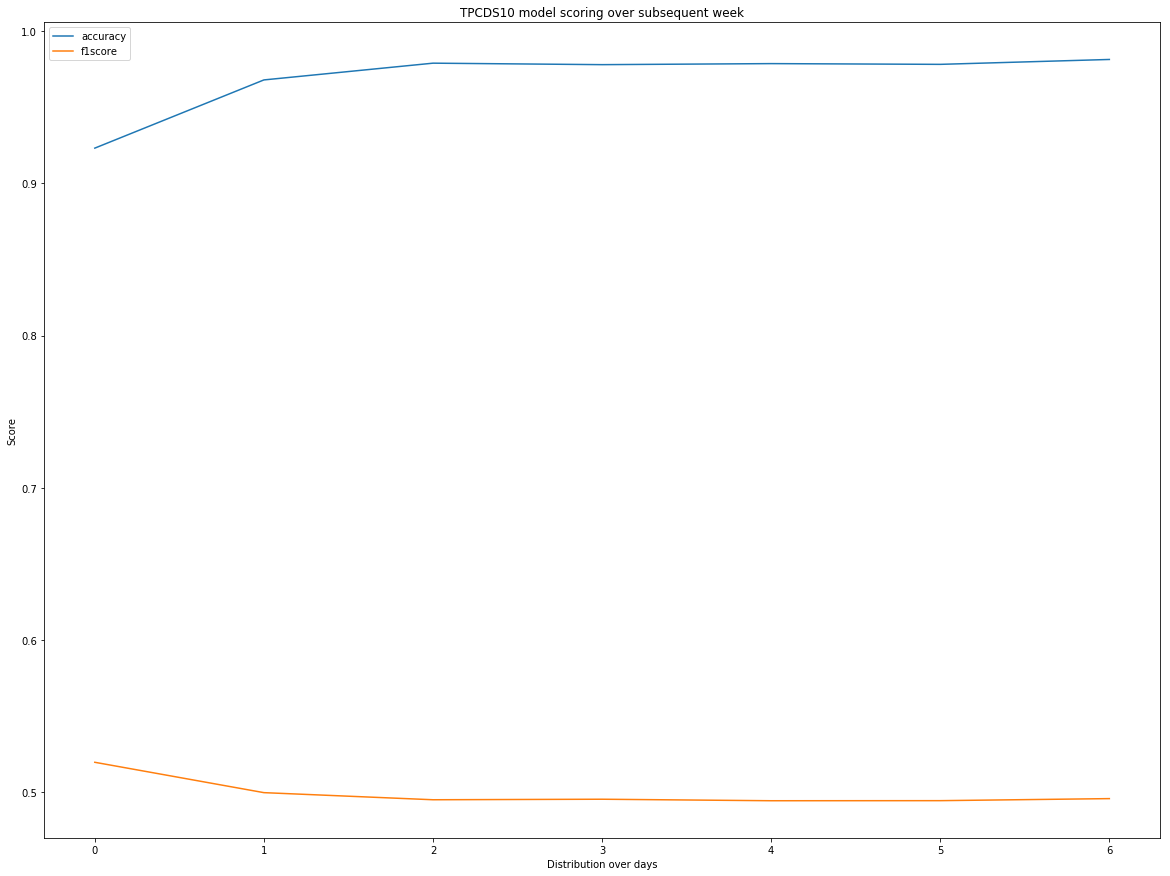

In [29]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (3) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(1999, 3, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(1999, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(1999, 3, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(1999, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 3, 85)             58140     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 85)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 85)                58140     
_________________________________________________________________
dropout_10 (Dropout)         (None, 85)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                2064      
Tot

Epoch 40/50
 - 3s - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1224 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1241
Epoch 41/50
 - 3s - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1223 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1241
Epoch 42/50
 - 3s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1218 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1241
Epoch 43/50
 - 3s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1218 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1242
Epoch 44/50
 - 3s - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1217 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1243
Epoch 45/50
 - 3s - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1214 - val_loss: 0.0405

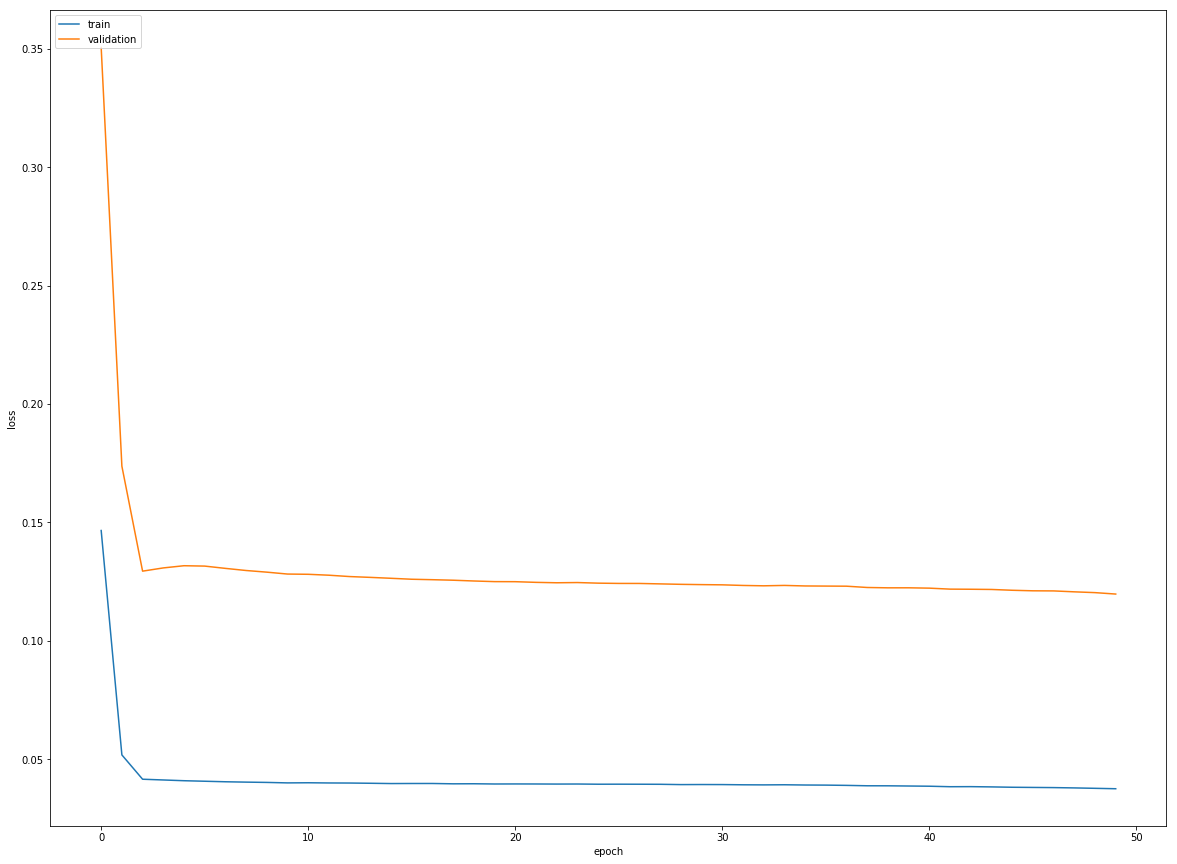

Wall time: 2min 33s


In [30]:
%%time
timestep = 3
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (3) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [31]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (285, 3, 85)
Label vectors: (285, 24)
Label: 0
Accuracy: 0.9894736842105263
F1Score: 0.9947089947089947
--------------------------
Label: 1
Accuracy: 0.9087719298245615
F1Score: 0.07142857142857144
--------------------------
Label: 2
Accuracy: 0.9859649122807017
F1Score: 0.9929328621908127
--------------------------
Label: 3
Accuracy: 0.8947368421052632
F1Score: 0.0625
--------------------------
Label: 4
Accuracy: 0.9894736842105263
F1Score: 0.9947089947089947
--------------------------
Label: 5
Accuracy: 0.8385964912280702
F1Score: 0.04166666666666667
--------------------------
Label: 6
Accuracy: 0.968421052631579
F1Score: 0.983957219251337
--------------------------
Label: 7
Accuracy: 0.8736842105263158
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9859649122807017
F1Score: 0.9929328621908127
--------------------------
Label: 9
Accuracy: 0.8666666666666667
F1Score: 0.05
--------------------------
Label: 10
Accuracy: 0.9824561403508771
F1Score: 0.

Label: 0
Accuracy: 0.9649122807017544
F1Score: 0.9821428571428572
--------------------------
Label: 1
Accuracy: 0.9649122807017544
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9649122807017544
F1Score: 0.9821428571428572
--------------------------
Label: 3
Accuracy: 0.9859649122807017
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9719298245614035
F1Score: 0.9857651245551602
--------------------------
Label: 5
Accuracy: 0.9929824561403509
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9789473684210527
F1Score: 0.9893617021276596
--------------------------
Label: 7
Accuracy: 0.9789473684210527
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9824561403508771
F1Score: 0.9911504424778761
--------------------------
Label: 9
Accuracy: 0.9929824561403509
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9859649122807017
F1Score: 0.9929328621908127
--------------------------
Label: 11
Accuracy: 0.9929824561403509
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9964912280701754
F1Score: 0.9982425307557118
--------------------------
Label: 1
Accuracy: 0.9824561403508771
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9894736842105263
F1Score: 0.9947089947089947
--------------------------
Label: 3
Accuracy: 0.9754385964912281
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9894736842105263
F1Score: 0.9947089947089947
--------------------------
Label: 5
Accuracy: 0.9789473684210527
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9964912280701754
F1Score: 0.9982425307557118
--------------------------
Label: 7
Accuracy: 0.9824561403508771
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9894736842105263
F1Score: 0.9947089947089947
--------------------------
Label: 9
Accuracy: 0.9929824561403509
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9789473684210527
F1Score: 0.9893617021276596
--------------------------
Label: 11
Accuracy: 0.9754385964912281
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9754385964912281
F1Score: 0.9875666074600356
--------------------------
Label: 1
Accuracy: 0.9578947368421052
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9649122807017544
F1Score: 0.9821428571428572
--------------------------
Label: 3
Accuracy: 0.9719298245614035
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9929824561403509
F1Score: 0.9964788732394366
--------------------------
Label: 5
Accuracy: 0.9859649122807017
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9789473684210527
F1Score: 0.9893617021276596
--------------------------
Label: 7
Accuracy: 0.9859649122807017
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9859649122807017
F1Score: 0.9929328621908127
--------------------------
Label: 9
Accuracy: 0.9824561403508771
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9964912280701754
F1Score: 0.9982425307557118
--------------------------
Label: 11
Accuracy: 0.9578947368421052
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

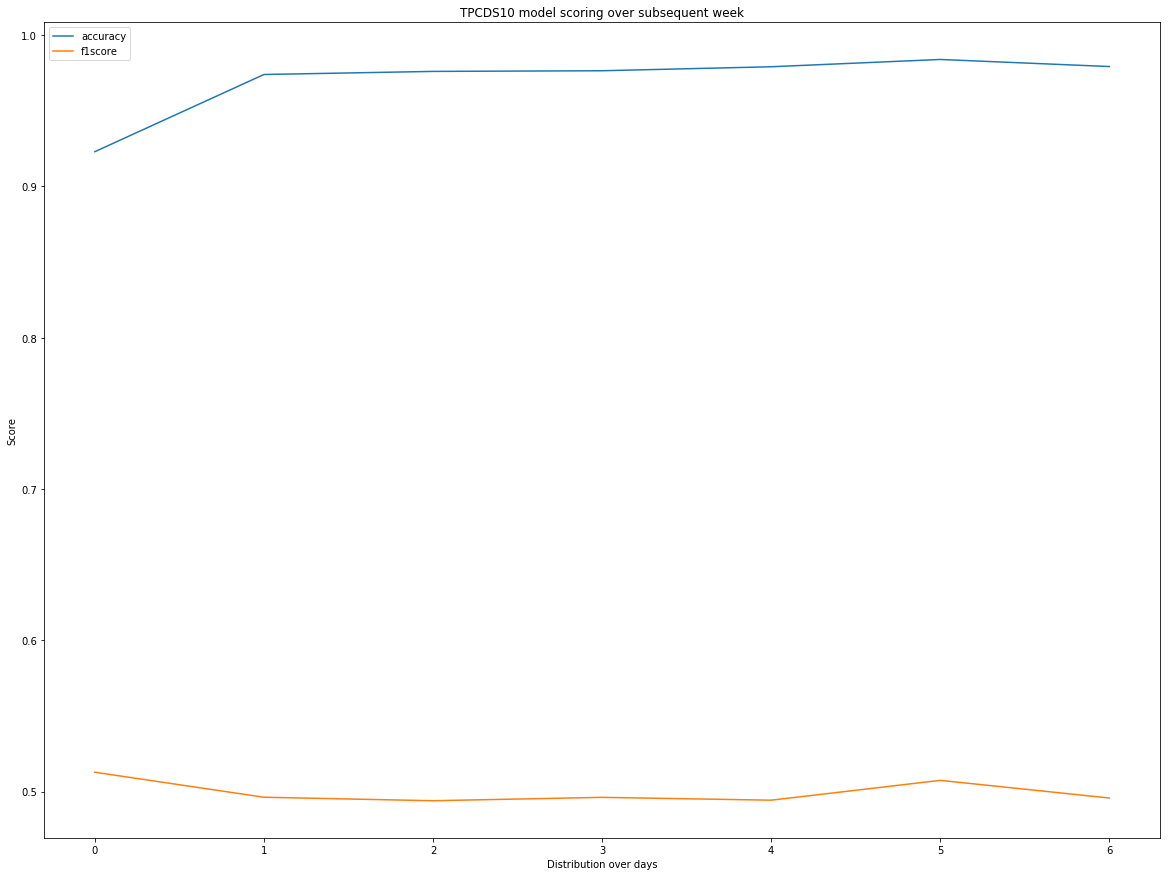

In [32]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (Equal to Lag) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(499, 12, 85)] Type - <class 'numpy.ndarray'>
y_train shape [(499, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(499, 12, 85)] Type - <class 'numpy.ndarray'>
y_validate shape [(499, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 12, 85)            58140     
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 85)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 85)                58140     
_________________________________________________________________
dropout_12 (Dropout)         (None, 85)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                2064      
Total

INFO:plaidml:Analyzing Ops: 2763 of 2778 operations complete


 - 21s - loss: 0.1611 - mean_squared_error: 0.1611 - mean_absolute_error: 0.3679 - val_loss: 0.1518 - val_mean_squared_error: 0.1518 - val_mean_absolute_error: 0.3565
Epoch 2/50
 - 2s - loss: 0.1397 - mean_squared_error: 0.1397 - mean_absolute_error: 0.3443 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - val_mean_absolute_error: 0.3005
Epoch 3/50
 - 2s - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2604 - val_loss: 0.0524 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1983
Epoch 4/50
 - 2s - loss: 0.0498 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1796 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1471
Epoch 5/50
 - 2s - loss: 0.0444 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1484 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1346
Epoch 6/50
 - 2s - loss: 0.0437 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1405 - val_loss: 0.0394 - val_mean_squa

Epoch 48/50
 - 2s - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1275 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1247
Epoch 49/50
 - 2s - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1272 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1247
Epoch 50/50
 - 2s - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1277 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1247


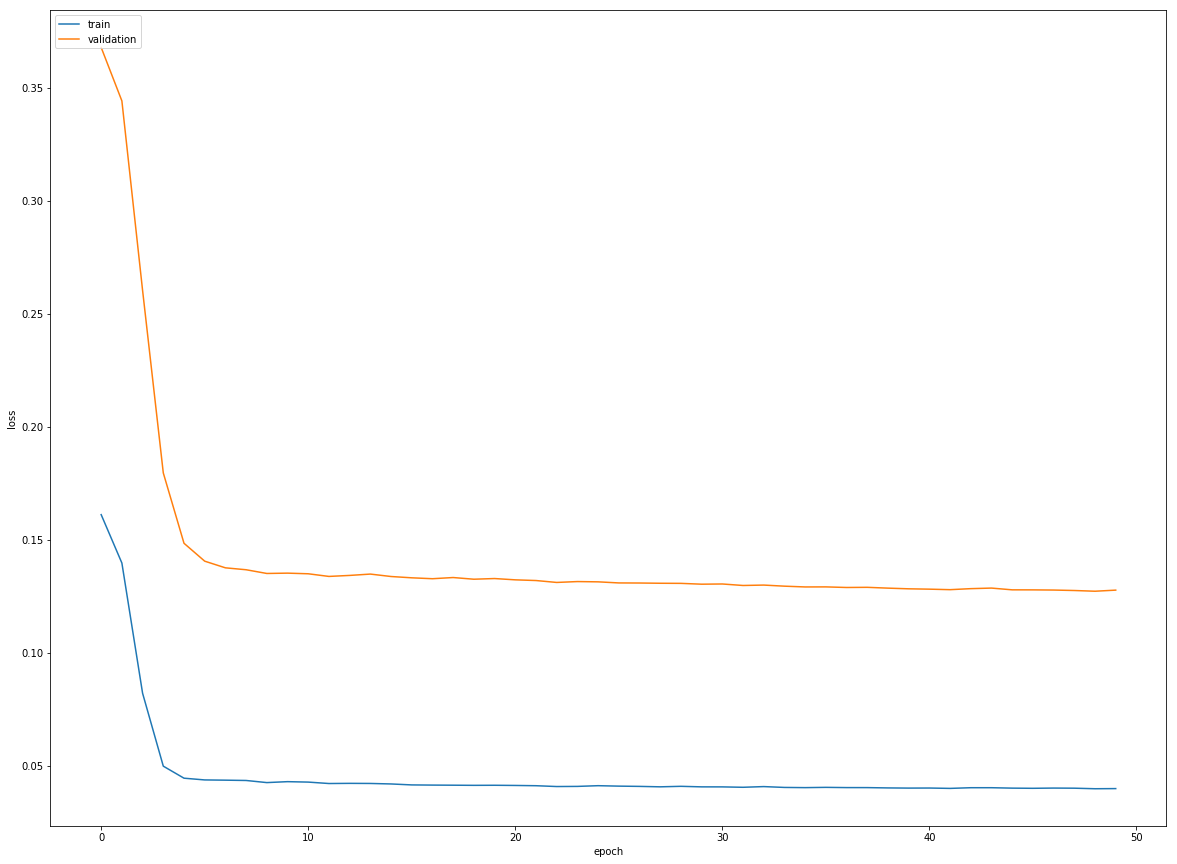

Wall time: 2min 18s


In [33]:
%%time
timestep = lag
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (Equal to Lag) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [34]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (71, 12, 85)
Label vectors: (71, 24)
Label: 0
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 1
Accuracy: 0.19718309859154928
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 3
Accuracy: 0.4647887323943662
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 5
Accuracy: 0.49295774647887325
F1Score: 0.052631578947368425
--------------------------
Label: 6
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 7
Accuracy: 0.28169014084507044
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9577464788732394
F1Score: 0.9784172661870503
--------------------------
Label: 9
Accuracy: 0.4084507042253521
F1Score: 0.04545454545454545
--------------------------
Label: 10
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 11
Accur

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Label: 0
Accuracy: 0.9577464788732394
F1Score: 0.9784172661870503
--------------------------
Label: 1
Accuracy: 0.028169014084507043
F1Score: 0.05479452054794521
--------------------------
Label: 2
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 3
Accuracy: 0.16901408450704225
F1Score: 0.06349206349206349
--------------------------
Label: 4
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 5
Accuracy: 0.04225352112676056
F1Score: 0.05555555555555556
--------------------------
Label: 6
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 7
Accuracy: 0.014084507042253521
F1Score: 0.02777777777777778
--------------------------
Label: 8
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 9
Accuracy: 0.23943661971830985
F1Score: 0.03571428571428572
--------------------------
Label: 10
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 11
Accuracy: 0.8732394366197183
F1Score: 0.0
--

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Label: 0
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 1
Accuracy: 0.8028169014084507
F1Score: 0.125
--------------------------
Label: 2
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 3
Accuracy: 0.9014084507042254
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 5
Accuracy: 0.5352112676056338
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 7
Accuracy: 0.5633802816901409
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 9
Accuracy: 0.9859154929577465
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 11
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9859154929

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is 

Label: 0
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 1
Accuracy: 0.6901408450704225
F1Score: 0.08333333333333334
--------------------------
Label: 2
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 3
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 5
Accuracy: 0.7464788732394366
F1Score: 0.1
--------------------------
Label: 6
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 7
Accuracy: 0.49295774647887325
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 9
Accuracy: 0.9577464788732394
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Label: 0
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 1
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 3
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 5
Accuracy: 0.9859154929577465
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 9
Accuracy: 0.9577464788732394
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 11
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 1.0
F1Score: 1.0
--------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

Label: 0
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 1
Accuracy: 0.8450704225352113
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 3
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 5
Accuracy: 0.9577464788732394
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 7
Accuracy: 0.9577464788732394
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 9
Accuracy: 0.9154929577464789
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.971830985915493
F1Score: 0.9857142857142858
--------------------------
Label: 11
Accuracy: 0.9859154929577465
F1Score: 0.0
---

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is 

Label: 0
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 1
Accuracy: 0.9436619718309859
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 3
Accuracy: 0.9859154929577465
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 1.0
F1Score: 1.0
--------------------------
Label: 5
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 7
Accuracy: 0.971830985915493
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9859154929577465
F1Score: 0.9929078014184397
--------------------------
Label: 9
Accuracy: 0.9859154929577465
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9577464788732394
F1Score: 0.9784172661870503
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9577464788732394
F1Score: 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

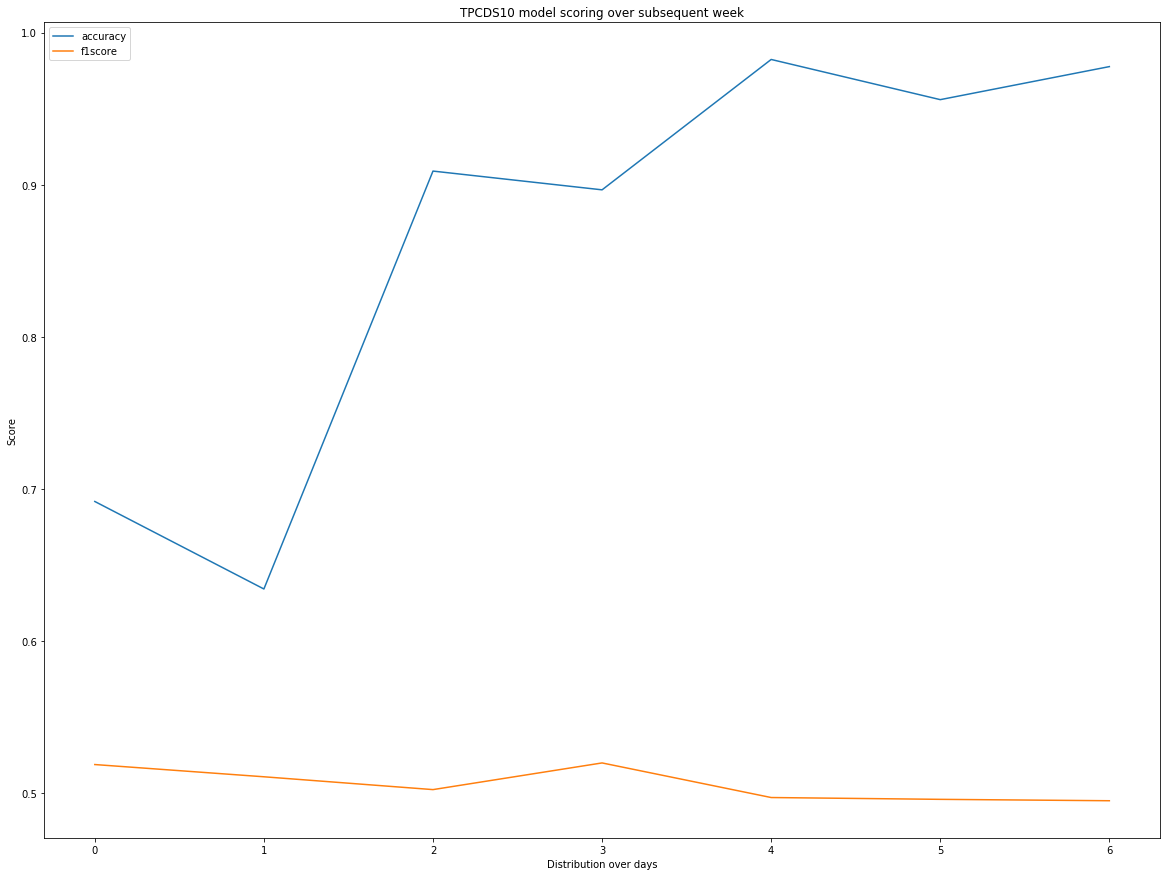

In [35]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()